===================<br>
**1. Get data and setup folders to use**  
1. connect to storage - this section is the primary one to be changed if not using google colab
2. define all the data paths
3. download the 25k image dataset, and extract it to the local machine (not remote storage)


In [2]:
# @title
# connect to colab
# configure all paths / folders to use for rest of notebook
# download and extract dataset

gdrive_path='/content/drive'
import os,zipfile
#import shutils
from google.colab import drive
drive.mount(gdrive_path)
dataset_source_address='https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
dataset_filename='kagglecatsanddogs_5340.zip'
dataset_gdrive_zip_folder=os.path.join(gdrive_path,'MyDrive','dataset_zips')
dataset_gdrive_zip_file=os.path.join(dataset_gdrive_zip_folder,dataset_filename)
dataset_parentdir='/tmp/data/'
temp_complete_dataset_dir=os.path.join(dataset_parentdir,'PetImages')
dataset_dir=os.path.join(dataset_parentdir,'splitdata')
dataset_temp_zip=os.path.join('/tmp',dataset_filename)
output_dir=os.path.join(gdrive_path,'MyDrive','output')
checkpoint_dir=os.path.join(output_dir,'checkpoints')

if not os.path.isdir(dataset_parentdir):
    print(f'creating {dataset_parentdir}')
    os.mkdir(dataset_parentdir)
if not os.path.isdir(output_dir):
    print(f'creating {output_dir}')
    os.mkdir(output_dir)
if not os.path.isdir(checkpoint_dir):
    print(f'creating {checkpoint_dir}')
    os.mkdir(checkpoint_dir)

if not os.path.isdir(dataset_gdrive_zip_folder):
    print(f'creating {dataset_gdrive_zip_folder}')
    os.mkdir(dataset_gdrive_zip_folder)

if not os.path.isfile(dataset_gdrive_zip_file):
  print(f'wget -P {dataset_gdrive_zip_folder} {dataset_source_address} ')
  !wget -P {dataset_gdrive_zip_folder} {dataset_source_address}

if not os.path.isdir(temp_complete_dataset_dir):
  with zipfile.ZipFile(dataset_gdrive_zip_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_parentdir)



Mounted at /content/drive
creating /tmp/data/


===================<br>
**2 Clean Dataset**.
- Process for this was taken from the Keras examples at  https://keras.io/examples/vision/image_classification_from_scratch/

In [4]:
# @title
# 2
# Clean dataset

#from here https://keras.io/examples/vision/image_classification_from_scratch/
import os
import tensorflow as tf

print("cleaning dataset (removing files that don't have the required header)")

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(temp_complete_dataset_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


cleaning dataset (removing files that don't have the required header)
Deleted 0 images


===================<br>
**3. split images into folders for train/validation/test (80%,10%,10%)**
- Splits the dataset into a classic train/validation/test split.
- This cannot be done using the tensorflow commands as that causes the memory to be exhausted for google colab

In [5]:
# @title
# 3
#Split cleaned dataset - doing this at the folder level to avoid OOM errors on Colab

!pip install split-folders

import splitfolders

if not os.path.isdir(dataset_dir):
  print(f'creating {dataset_dir}')
  os.mkdir(dataset_dir)

  print('splitting dataset into train/validation/test')
  splitfolders.ratio(input=temp_complete_dataset_dir, output=dataset_dir, ratio=(.8, 0.1,0.1))

print('dataset parentdir folder:')
print(os.listdir(dataset_parentdir))

print('dataset folder:')
print(os.listdir(dataset_dir))

train_dataset_dir=os.path.join(dataset_dir,'train')
val_dataset_dir=os.path.join(dataset_dir,'val')
test_dataset_dir=os.path.join(dataset_dir,'test')

creating /tmp/data/splitdata
splitting dataset into train/validation/test


Copying files: 23412 files [00:05, 4551.27 files/s]

dataset parentdir folder:
['readme[1].txt', 'CDLA-Permissive-2.0.pdf', 'PetImages', 'splitdata']
dataset folder:
['test', 'train', 'val']


===================<br>
**4. set variables to use**
1. check the number of classes in the dataset (at this point the folder structure should be dataset_dir\train\class1\image1.jpg)
2. based on the number of classes, determine if we are doing binary classification or categorical classification and set variables appropriately for later use.

Parameters for this section - are
- the Network architecture to use.
- Whether to use pre-trained weights (weights='imagenet') or random weights (weights=None)
- initial learning rate to use.

In [6]:
# @title
# 4
# check dataset for number of classes & set variables
# load model
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

architecture='xception'
weights='imagenet'
base_learning_rate=0.02

# set weights to 'imagenet' or None

n_classes=max(len(os.listdir(train_dataset_dir)),len(os.listdir(val_dataset_dir)),len(os.listdir(test_dataset_dir)))
if(n_classes>2):
    label_mode='categorical'
    loss_function=tf.keras.losses.CategoricalCrossentropy
    prediction_layer=tf.keras.layers.Dense(n_classes,activation='softmax')
else:
    label_mode='binary'
    loss_function=tf.keras.losses.BinaryCrossentropy
    prediction_layer=tf.keras.layers.Dense(1,activation='sigmoid')

#Clear any already loaded data
tf.keras.backend.clear_session()
train_acc=[]
val_acc=[]
train_loss=[]
val_loss=[]

tfKerasApps=tf.keras.applications
base_arch_func=None
base_model=None
# get model name and preprocessing functions for the provided architecture
# e.g. tf.keras.applications.vgg16
try:
    base_arch_func=getattr(tfKerasApps, architecture)
    archDisplayName=dir(base_arch_func)[0]
    base_model_func=getattr(base_arch_func, archDisplayName)
    preprocess_input=getattr(base_arch_func, 'preprocess_input')
except AttributeError:
    print(f'function not found - was architecture correctly provided?')

tf.keras.backend.clear_session()

#Get model shapes by loading a temporary version of the model
temp_model=base_model_func(weights=None)
preferred_input_shape=temp_model.get_build_config().get('input_shape')[1:]
preferred_image_size=preferred_input_shape[:2]
temp_model=None

tf.keras.backend.clear_session()


TensorFlow version: 2.13.0


===================<br>
**5. Build Model**, use for transfer learning Or learning from random weights
1. configure data augmentation to use (randomly change images)
2. Build the model to use.
- if weights=imagenet, then setup for transfer learning, otherwise for learning from scratch.


In [7]:
# @title
#Build model
if(weights == 'imagenet'):
  weightsName=weights
else:
  weightsName='random'

print(f'building {archDisplayName} model with {weightsName} weights')

#print(f'loading {archDisplayName} model with {weights} weights')
base_model=base_model_func(
    include_top=False,
    weights=weights,
    input_shape=preferred_input_shape,
    pooling='avg')

if(weights == 'imagenet'):
  base_model.trainable = False
else:
  base_model.trainable = True

# randomize things a bit mre with the training images:
augments=[]
augments_name=''
augments_name=augments_name+'Flip'
augments = augments + [tf.keras.layers.RandomFlip('horizontal')]
augments_name=augments_name+'Rotate'
augments = augments + [tf.keras.layers.RandomRotation(0.3)]
augments_name=augments_name+'Zoom'
augments = augments + [tf.keras.layers.RandomZoom(0.2)]
augments_name='Random'+augments_name
data_augmentation = tf.keras.Sequential(augments,name=augments_name)
augmentation_step_count=len(augments)

inputs = tf.keras.Input(shape=preferred_input_shape)
if(augmentation_step_count > 0):
  x = data_augmentation(inputs)
  x = preprocess_input(x)
else:
  x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs,name=archDisplayName)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                    loss=loss_function(from_logits=False),
                    metrics=['accuracy'])

model.summary(show_trainable=True)

initial_epoch=0

building Xception model with imagenet weights
83683744/83683744 [==============================] - 5s 0us/step
Model: "Xception"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         Y          
                                                                            
 RandomFlipRotateZoom (Sequ  (None, 299, 299, 3)       0         Y          
 ential)                                                                    
                                                                            
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         Y          
 a)                                                                         
                                                                            
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         Y          
 da)                    

===================<br>
**6. Load Datasets**

In [8]:
# @title
print('loading training dataset')
train_ds=tf.keras.utils.image_dataset_from_directory(train_dataset_dir,labels='inferred',label_mode=label_mode,image_size=preferred_image_size)
print('loading validation dataset')
validation_ds=tf.keras.utils.image_dataset_from_directory(val_dataset_dir,labels='inferred',label_mode=label_mode,image_size=preferred_image_size)
print('loading test dataset')
# note shuffle set to False for the test dataset
# so that the confusion matrix displayed at the end
# displays valid values.
test_ds=tf.keras.utils.image_dataset_from_directory(test_dataset_dir,labels='inferred',label_mode=label_mode,image_size=preferred_image_size,shuffle=False)
class_names=test_ds.class_names


loading training dataset
Found 18728 files belonging to 2 classes.
loading validation dataset
Found 2340 files belonging to 2 classes.
loading test dataset
Found 2342 files belonging to 2 classes.


===================<br>
**7. Get untrained accuracy** (Optional)
- Get the accuracy of the model against the test dataset prior to any training - use for comparison purposes

In [18]:
# @title
#Evaluate accuracy without further training.

#evaluate takes ~15 min on colab when using CPU or ~ 30s when using GPU (once data is loaded)
(initialAccuracy,initial_loss)=model.evaluate(test_ds)

74/74 [==============================] - 18s 214ms/step - loss: 0.6545 - accuracy: 0.6661


===================<br>
**8. Setup callbacks and start training**
1. Build callbacks
  - Early Stopping - if validation accuracy isn't improving
  - reduceLrOnPlateau - if training accuracy isn't improving (do this sooner than the early stopping one
  - Checkpoint - save a copy of the model when the best results are obtained (useful if google colab session times out). The methods to load this are beyond the scope of this notebook.

2. setup dataset autotuning. In theory this speeds up training by reducing idle time on GPU - by ensuring fresh data is available for processing all the time.

3. start the training. This takes a while - especially if training from random weights.
Note the number of trainable parameters in use - this changes depending on whether random weights are used or imagenet weights are used. As per the EarlyStopping setting, this may stop before the full number of epochs are reached.

Parameters for this section:
- number of epochs
- early stopping patience (epoch number)
- learning rate patience (count of epoch with no improvement to accuracy before reducint learning rate)

In [11]:
# @title
# Setup callbacks
#then try & train the model.

import time

epochs=10
#Early Stopping Patience (epoch Count)
es_patience=5
#Learning Rate Patience (epoch Count)
lr_patience=3

train_id = str(int(time.time()))

callbacks=[]
callbacks = callbacks + [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=es_patience)]
callbacks=callbacks +[tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, min_delta=0.005,
                      patience=lr_patience, min_lr=base_learning_rate/1000)]

callbacks=callbacks +[tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    mode='auto',
    save_freq='epoch')]

# set up autotuning to try & speed things up:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print(f"es_patience={es_patience}")
print(f"lr_patience={lr_patience} (current: {base_learning_rate})")

start = time.time()

history = model.fit(train_ds,
    initial_epoch=initial_epoch,
    epochs=(initial_epoch+epochs),
    validation_data=validation_ds,
    callbacks=callbacks,
    validation_freq=1)

end = time.time()
print(f'{archDisplayName} Duration of train: {(end-start)/60:.1f} minutes\n')

train_acc=train_acc + history.history['accuracy']
val_acc=val_acc + history.history['val_accuracy']
train_loss = train_loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"{archDisplayName} - Test accuracy :", test_accuracy)


es_patience=5
lr_patience=3 (current: 0.0002)
Epoch 11/20
586/586 [==============================] - 585s 939ms/step - loss: 0.1168 - accuracy: 0.9573 - val_loss: 0.0385 - val_accuracy: 0.9868 - lr: 2.0000e-04
Epoch 12/20
586/586 [==============================] - 526s 896ms/step - loss: 0.0663 - accuracy: 0.9754 - val_loss: 0.0466 - val_accuracy: 0.9803 - lr: 2.0000e-04
Epoch 13/20
586/586 [==============================] - 545s 929ms/step - loss: 0.0572 - accuracy: 0.9777 - val_loss: 0.0240 - val_accuracy: 0.9902 - lr: 2.0000e-04
Epoch 14/20
586/586 [==============================] - 525s 895ms/step - loss: 0.0539 - accuracy: 0.9797 - val_loss: 0.0299 - val_accuracy: 0.9863 - lr: 2.0000e-04
Epoch 15/20
586/586 [==============================] - 523s 892ms/step - loss: 0.0510 - accuracy: 0.9809 - val_loss: 0.0330 - val_accuracy: 0.9855 - lr: 2.0000e-04
Epoch 16/20
586/586 [==============================] - 525s 895ms/step - loss: 0.0463 - accuracy: 0.9837 - val_loss: 0.0336 - val_accu

**9. if using pre-trained weights - reconfigure model for fine tuning.**

NB: - you need to re-run the previous training step to do the training after this section.

In [10]:
# @title
if (weights == 'imagenet' and history is not None):
    #Train the bottom half of the layers (half the number of parameters)
    base_model.trainable=True
    base_learning_rate=base_learning_rate/100

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                        loss=loss_function(from_logits=False),
                        metrics=['accuracy'])

    model.summary(show_trainable=True)

    initial_epoch=len(history.epoch)
else:
  if (weights == 'imagenet'):
    print('perform model before this section')
  else:
    print('This section is not relelvant when training using random weights')

Model: "Xception"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         Y          
                                                                            
 RandomFlipRotateZoom (Sequ  (None, 299, 299, 3)       0         Y          
 ential)                                                                    
                                                                            
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         Y          
 a)                                                                         
                                                                            
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         Y          
 da)                                                                        
                                                          

===================<br>
**Eighth section**
- Save the model

In [12]:
# @title
model_path=os.path.join(output_dir
        ,'saved_models')
if not os.path.isdir(model_path):
    os.mkdir(model_path)
save_path = os.path.join(model_path,
        f'{architecture}_{train_id}')
print(f'saving {architecture} model to file "{save_path}"')
model.save(save_path)



saving xception model to file "/content/drive/MyDrive/output/saved_models/xception_1696475109"


===================<br>
**Ninth Section**
- Plot training results.

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chief_worker_only', '_implements_predict_batch_hooks', '_implements_test_batch_hooks', '_implements_train_batch_hooks', '_keras_api_names', '_keras_api_names_v1', '_supports_tf_logs', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_predict_batch_begin', 'on_predict_batch_end', 'on_predict_begin', 'on_predict_end', 'on_test_batch_begin', 'on_test_batch_end', 'on_test_begin', 'on_test_end', 'on_train_batch_begin', 'on_train_batch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']
{8}
{10}
[0.1167530044913292, 0.14255152642726898, 0.13006266951560974, 

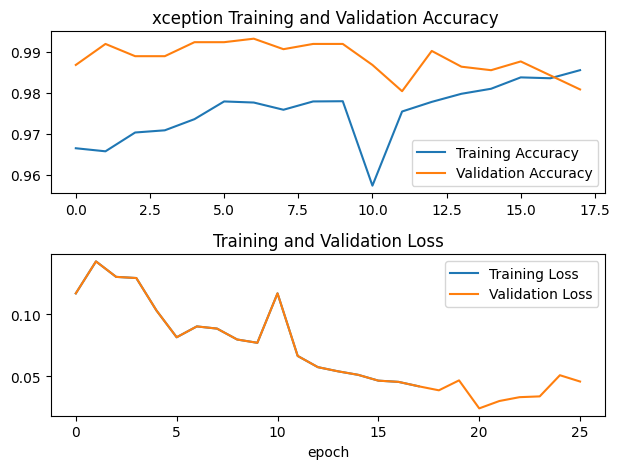

In [19]:
# @title

plot_model_filepath=os.path.join(output_dir,f'{architecture}_model.png')
tf.keras.utils.plot_model(model,to_file=plot_model_filepath)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
#ax1.set_ylim([0.5, 1])
#if weights == 'imagenet':
#    ax1.plot([epochs-1,epochs-1],
#        ax1.get_ylim(), label='Start Fine Tuning')
ax1.legend(loc='lower right')
ax1.set_title(f'{architecture} Training and Validation Accuracy ')

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
#ax2.set_ylim([0, 1.0])
#if weights == 'imagenet':
#    ax2.plot([epochs-1,epochs-1],
#        ax2.get_ylim(), label='Start Fine Tuning')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')
fig.tight_layout()
fig_filename=os.path.join(f'{output_dir}',
        f'{archDisplayName}-{epochs}-{epochs}-{weights}-{train_id}')
fig.savefig(fname=fig_filename)


**Tenth Section**
- generate confusion matrix & heatmap

74/74 [==============================] - 19s 238ms/step
tf.Tensor(
[[1165   10]
 [  17 1150]], shape=(2, 2), dtype=int32)


<function matplotlib.pyplot.show(close=None, block=None)>

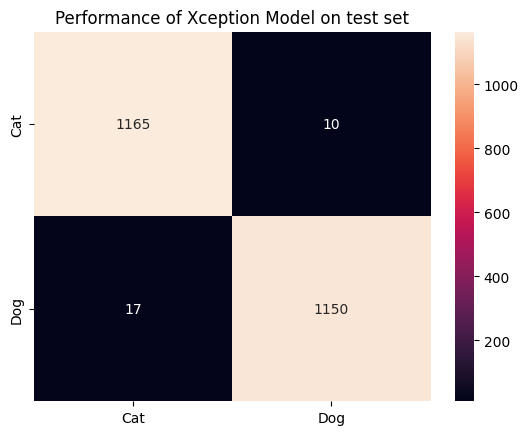

In [20]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#get predictions
predictResults=model.predict(test_ds)
#if < 0.5 then 0, otherwise 1
predictions = tf.where(predictResults.flatten() < 0.5, 0, 1)
# convert to 1D array (needed for confusion matrix)
predictions=tf.reshape(predictions,-1)

#get all labels of the dataset
labels_iterator= test_ds.unbatch().map(lambda x_int, y_str: y_str).as_numpy_iterator()
labels = np.array(list(labels_iterator))

#print(len(labels))
#print(len(predictions))

#generate the confusion matrix
cf=tf.math.confusion_matrix(labels,predictions)
print(cf)

#generate the heatmap
sns.heatmap(cf, annot= True, xticklabels = class_names, fmt='.10g',
           yticklabels = class_names)
plt.title(f'Performance of {archDisplayName} Model on test set')
plt.show

**unused / optional**<br>
Load model & weights (but not history) from saved checkpoint

In [16]:
print(os.listdir(checkpoint_dir))
model = tf.keras.models.load_model(checkpoint_dir,compile=True)


['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']
